# Setup Functions

## Imports

In [67]:
from scipy.io import loadmat, savemat
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output
import math
import time
import cvxpy as cp
import numpy as np
from tqdm import tqdm



## Other Functions

In [58]:
def find_least_t_with_max_indices(Q, D, tol=1e-10):
    """
    Q, D: torch.Tensor (square, symmetric), shape (n,n)
    Checks inequalities for i<j in [0..5].
    Returns (max_ratio: float, max_indices: list of (i,j))
    """
    max_ratio = 1.0
    max_indices = []
    n = Q.shape[0]

    for i in range(n):
        for j in range(i + 1, n):
            lhs = Q[i, i] - 2 * Q[i, j] + Q[j, j]
            dij = D[i, j]

            if lhs < dij - tol:
                raise ValueError(f"Lower bound violated at ({i},{j}): LHS={lhs.item()}, D={dij.item()}")

            if dij > tol:
                ratio = lhs / dij
                if torch.abs(ratio - max_ratio) < tol:
                    max_indices.append((i, j))
                elif ratio > max_ratio + tol:
                    max_ratio = ratio.item()
                    max_indices = [(i, j)]

    return max_ratio, max_indices


## Loss Functions

In [59]:
def project_to_fundamental_domain(X):
    """
    Map each point in X to the [0,1] x [0,1] fundamental domain
    using mod-2 translation and up to 3 rotations about (1,1).
    X is modified in place.
    """

    X_proj = X.clone()
    # Mod out by lattice (0,2) and (2,0)
    X_proj.data = X_proj.data % 2.0

    # Rotation matrix for pi/2 about (1,1)
    def rotate(x):
        center = torch.tensor([[1.0], [1.0]], device=x.device, dtype=x.dtype)
        R = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device=x.device, dtype=x.dtype)
        return R @ (x - center) + center

    def is_in_unit_square(x):
        return ((x[0] >= 0) & (x[0] <= 1) & (x[1] >= 0) & (x[1] <= 1))

    for i in range(X.shape[1]):
        x = X_proj.data[:, i:i+1]  # shape (2,1)
        for _ in range(4):
            if is_in_unit_square(x):
                break
            x = rotate(x)
        X_proj.data[:, i] = x.squeeze()

    return X_proj

def compute_D(X):
    """
    X: torch.Tensor, shape (2, n)
    Returns: D: torch.Tensor, shape (n, n)
    """
    n = X.shape[1]

    X_proj = project_to_fundamental_domain(X)

    A_all = torch.stack([
        torch.eye(2),                         # identity
        torch.tensor([[0, -1], [1, 0]]),     # g1
        torch.tensor([[-1, 0], [0, -1]]),    # g1^2
        torch.tensor([[0, 1], [-1, 0]]),     # g1^3
        torch.tensor([[-1, 0], [0, -1]]),    # g2
        torch.tensor([[-1, 0], [0, -1]]),    # g3
        torch.tensor([[0, -1], [1, 0]]),     # g4
        torch.tensor([[-1, 0], [0, -1]]),    # g4^2
        torch.tensor([[0, 1], [-1, 0]])      # g4^3
    ], dim=2)  # shape (2, 2, 9)

    b_all = torch.tensor([
        [0, 0],    # identity
        [0, 0],    # g1
        [0, 0],    # g1^2
        [0, 0],    # g1^3
        [2, 0],    # g2
        [0, 2],    # g3
        [2, 0],    # g4
        [2, 2],    # g4^2
        [0, 2]     # g4^3
    ], dtype=X_proj.dtype).T  # shape (2, 9)

    D = torch.zeros((n, n), dtype=X_proj.dtype, device=X_proj.device)

    for ii in range(n):
        x = X_proj[:, ii].unsqueeze(1)  # shape (2,1)
        for jj in range(n):
            y = X_proj[:, jj].unsqueeze(1)  # shape (2,1)

            # Compute all 9 transformations: (A_all @ y) + b_all
            y_transformed = torch.bmm(A_all.permute(2, 0, 1), y.expand(9, 2, 1))  # (9,2,1)
            y_transformed = y_transformed.squeeze(2) + b_all.T  # shape (9, 2)

            # Compute distances squared: ||x - y_transformed||^2
            diff = y_transformed - x.T  # shape (9, 2)
            dist_squared = torch.sum(diff**2, dim=1)  # shape (9,)

            D[ii, jj] = torch.min(dist_squared)

    return D


def create_X(n, device=None, dtype=torch.float32):
    """
    Replicates the MATLAB X creation in PyTorch.

    Returns X: shape (2, n), dtype, device
    """
    k = int(round(n ** 0.5))
    points = []

    for ii in range(1, k + 1):
        for jj in range(1, k + 1):
            x1 = (ii - 1) / k
            x2 = (jj - 1) / (k - 1) if k > 1 else 0
            points.append([x1, x2])

    X = torch.tensor(points, dtype=dtype, device=device).T  # shape (2, n)
    return X

def compute_lhs(Q):
    """Precompute the fixed LHS matrix."""
    diag = torch.diagonal(Q)
    lhs = diag.unsqueeze(0) - 2 * Q + diag.unsqueeze(1)
    return lhs

# Q: fixed tensor (n,n)
# X: variable tensor (2, n) with requires_grad=True

def get_t_and_violations(lhs_fixed, D, tol=1e-6):
    n = D.shape[0]
    mask = torch.triu(torch.ones(n,n), diagonal=1).bool()  # upper triangle mask without diagonal

    lhs = lhs_fixed  # precomputed LHS

    D_masked = D[mask]
    lhs_masked = lhs[mask]

    # Check lower bounds
    violations = (D_masked > lhs_masked + tol)  # bool mask

    if violations.any():
        idx_flat = violations.nonzero(as_tuple=False).squeeze()
        i_all, j_all = mask.nonzero(as_tuple=True)
        idx_flat = idx_flat.view(-1)  # Ensure 1D
        violation_pairs = [(i_all[i].item(), j_all[i].item()) for i in idx_flat]
        return None, violation_pairs

    # Compute t and locate max ratio
    safe_D = D_masked.clamp(min=tol)
    ratios = lhs_masked / safe_D

    if torch.isnan(ratios).any():
        print("Warning: NaNs in ratios")
    if torch.isinf(ratios).any():
        print("Warning: Infs in ratios")

    valid = D_masked > tol
    ratios = torch.where(valid, lhs_masked / D_masked, torch.tensor(float('-inf'), device=D.device))
    t = torch.max(ratios)

    max_mask = (ratios >= t - tol)
    idx_flat = max_mask.nonzero(as_tuple=False).squeeze()
    idx_flat = idx_flat.view(-1)  # Ensure 1D

    i_all, j_all = mask.nonzero(as_tuple=True)
    max_pairs = [(i_all[i].item(), j_all[i].item()) for i in idx_flat]

    return t, max_pairs

# Then define a loss function:
def loss_fn(X, lhs_fixed, tol=1e-6):
    D = compute_D(X)
    n = D.shape[0]
    mask = torch.triu(torch.ones(n, n, device=X.device), diagonal=1).bool()

    D_masked = D[mask]
    lhs_masked = lhs_fixed[mask]

    penalty = torch.relu(D_masked - lhs_masked).sum() * 1e6
    ratios = lhs_masked / (D_masked + 1e-12)
    max_ratio = torch.max(ratios)

    loss = - max_ratio + penalty
    return loss



## Plot Functions

In [60]:
def plot_X_with_annotations(X, epoch=None):
    X_np = X.detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(X_np[0], X_np[1], s=20, c='blue')

    for i in range(X.shape[1]):
        ax.text(X_np[0, i] + 0.01, X_np[1, i] + 0.01, str(i), fontsize=8)

    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title(f"Epoch {epoch}")
    ax.grid(True)
    plt.show()

def update_plot_jupyter(X, epoch=None, t=None, max_indices=None):
    X_proj = project_to_fundamental_domain(X)
    X_np = X_proj.detach().cpu().numpy()

    clear_output(wait=True)

    # Plot the points
    plt.figure(figsize=(4, 4))
    plt.scatter(X_np[0], X_np[1], s=20, c='blue')

    for i in range(X.shape[1]):
        plt.text(X_np[0, i] + 0.01, X_np[1, i] + 0.01, str(i), fontsize=8)

    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.gca().set_aspect('equal')
    plt.title(f"Epoch {epoch}")
    plt.grid(True)
    plt.show()

    # Reprint training info
    if t is not None:
        display(Markdown(f"**Epoch {epoch}**, t = `{t:.6f}`, max indices = `{max_indices}`"))
    else:
        display(Markdown(f"**Epoch {epoch}**, t = `None`, violation indices = `{max_indices}`"))

def update_t_plot(t_history):
    plt.figure(figsize=(6, 3))
    plt.plot(t_history, marker='o', linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("t (distortion upper bound)")
    plt.title("Evolution of t over training")
    plt.grid(True)
    plt.show()

def update_loss_plot(loss_history):
    plt.figure(figsize=(6, 3))
    plt.plot(loss_history, marker='x', linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Time")
    plt.grid(True)
    plt.show()

def update_max_norm_plot(max_norm_history):
    plt.figure(figsize=(6, 3))
    plt.plot(max_norm_history, color='purple', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Max Norm of X[:, i]")
    plt.title("Max Norm per Epoch")
    plt.grid(True)
    plt.show()

## Reading Code

In [61]:
def read_matlab(n, base_path='../saved_data'):
    mat_path_Q = f'{base_path}/{n}/Q_{n}.mat'
    mat_path_D = f'{base_path}/{n}/D_{n}.mat'

    data_Q = loadmat(mat_path_Q)
    data_D = loadmat(mat_path_D)

    Q = torch.tensor(data_Q['Q'], dtype=torch.float32)
    D = torch.tensor(data_D['D'], dtype=torch.float32)

    if Q.shape[0] != D.shape[0]:
        raise ValueError("Q and D must have the same size.")

    lhs_fixed = compute_lhs(Q)
    X_init = create_X(Q.shape[0], device=Q.device, dtype=Q.dtype)

    return Q, D, lhs_fixed, X_init

## CVX Code

In [ ]:
def solve_cvx_for_history(X_history, compute_D):
    t_history_cvx = []
    Q_history_cvx = []

    for X_torch in tqdm(X_history, desc="Solving CVX for each X"):
        # Compute D as numpy array
        D_torch = compute_D(X_torch)
        D = D_torch.cpu().numpy()  # convert to numpy, assuming X and compute_D use torch

        n = D.shape[0]
        Q = cp.Variable((n, n), symmetric=True)
        t = cp.Variable()

        constraints = []
        constraints.append(Q >> 0)
        constraints.append(Q @ np.ones((n, 1)) == 0)

        for ii in range(n):
            for jj in range(n):
                lhs = Q[ii, ii] - 2 * Q[ii, jj] + Q[jj, jj]
                constraints.append(lhs >= D[ii, jj])
                constraints.append(lhs <= t * D[ii, jj])

        objective = cp.Minimize(t)
        prob = cp.Problem(objective, constraints)

        # Solve, choose solver you have installed
        prob.solve(solver=cp.SCS, verbose=False)

        if prob.status not in ["infeasible", "unbounded"]:
            t_history_cvx.append(t.value)
            Q_history_cvx.append(Q.value)
        else:
            t_history_cvx.append(None)
            Q_history_cvx.append(None)

    return t_history_cvx, Q_history_cvx

## Random Gaussian 

In [102]:
def generate_random_X_history(num_samples, n, device='cpu', seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    X_history = []
    for _ in range(num_samples):
        X = torch.rand((2, n), device=device)
        X_history.append(X)
    return X_history

# Define n (number of points)
n = 36  # or any other number

# Generate random X history
X_gaussian = generate_random_X_history(num_samples=20, n=n, seed=42)

# Call your solver
t_gaussian, Q_gaussian = solve_cvx_for_history(X_gaussian, compute_D)

Solving CVX for each X: 100%|██████████| 20/20 [03:33<00:00, 10.69s/it]


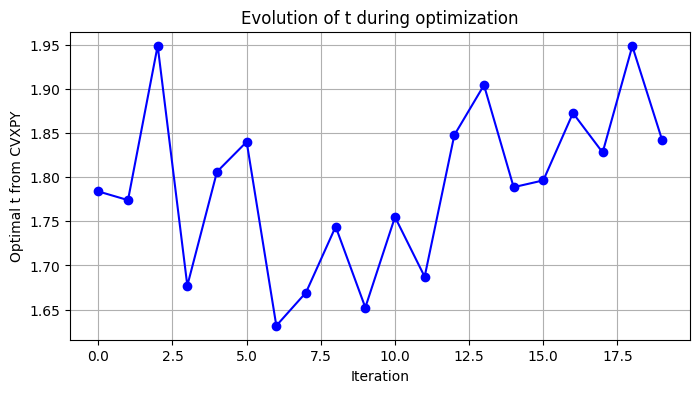

In [103]:
t_vals = [val if val is not None else float('nan') for val in t_gaussian]

plt.figure(figsize=(8,4))
plt.plot(t_vals, marker='o', linestyle='-', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Optimal t from CVXPY')
plt.title('Evolution of t during optimization')
plt.grid(True)
plt.show()

# Training without interleaving

## Training without interleaving

In [55]:
Q, D, lhs_fixed, X_init = read_matlab(25)
print((2 * math.sqrt(2 - math.sqrt(2)))**2)  # This is the lower bound

2.3431457505076194


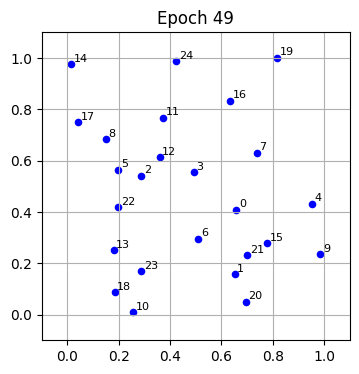

**Epoch 49**, t = `2.310321`, max indices = `[(15, 21)]`

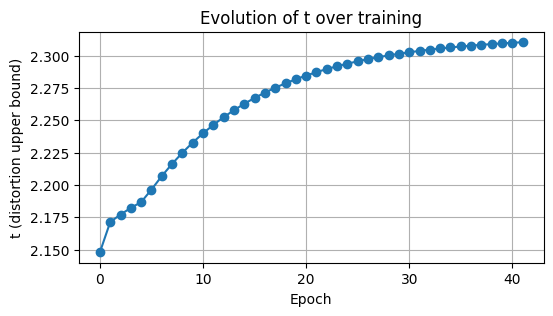

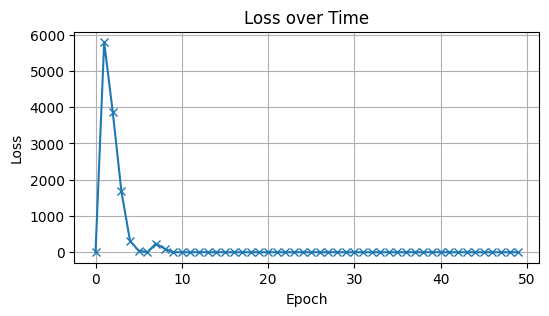

In [97]:
#X = X_init.clone().detach().requires_grad_(True)
X = X_gaussian[15].detach().clone().requires_grad_(True) 
t_init, Q_init = solve_cvx_for_history([X.clone().detach()], compute_D)
lhs_fixed = compute_lhs(torch.tensor(Q_init[0]))

optimizer = torch.optim.Adam([X], lr=1e-3)

best_t = -float('inf')
best_X = None  # Will hold the best X (i.e. when t is largest)
loss_history = []
t_history = []
max_norm_history = []
X_history = []

for epoch in range(50):
    optimizer.zero_grad()
    loss = loss_fn(X, lhs_fixed)
    loss.backward()
    with torch.no_grad():
        X_history.append(X.clone().detach())
        t, max_indices = get_t_and_violations(lhs_fixed, compute_D(X))
        max_norm = torch.norm(X, dim=0).max().item()
        max_norm_history.append(max_norm)
        if t is not None:
            t_val = t.item()
            t_history.append(t_val)
            if t_val > best_t:
                best_t = t_val
                best_X = X.detach().clone()

        else:
            t_val = None


    optimizer.step()

    loss_history.append(loss.item())

    #print(max_norm)
    # Show evolving plot and stats
    update_plot_jupyter(X, epoch, t_val, max_indices)

    if t_history:
        update_t_plot(t_history)
        update_loss_plot(loss_history)
        #update_max_norm_plot(max_norm_history)
    


In [84]:
proj_best_X = project_to_fundamental_domain(best_X)
savemat('../saved_data/python/25/X.mat', {'X': proj_best_X.cpu().numpy()})

## CVX

In [98]:
t_hist_cvx, Q_hist_cvx = solve_cvx_for_history(X_history, compute_D)

Solving CVX for each X: 100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


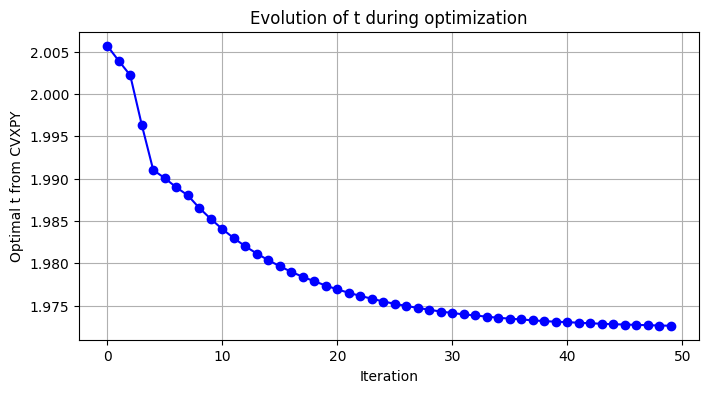

In [99]:
t_vals = [val if val is not None else float('nan') for val in t_hist_cvx]

plt.figure(figsize=(8,4))
plt.plot(t_vals, marker='o', linestyle='-', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Optimal t from CVXPY')
plt.title('Evolution of t during optimization')
plt.grid(True)
plt.show()

# Training with interleaving

## Training with interleaving

In [ ]:
Q, D, lhs_fixed, X_init = read_matlab(25)
print((2 * math.sqrt(2 - math.sqrt(2)))**2)  # This is the lower bound

2.3431457505076194


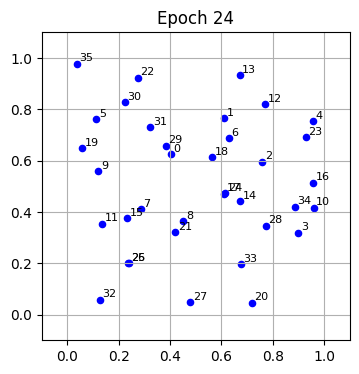

**Epoch 24**, t = `None`, violation indices = `[(7, 35)]`

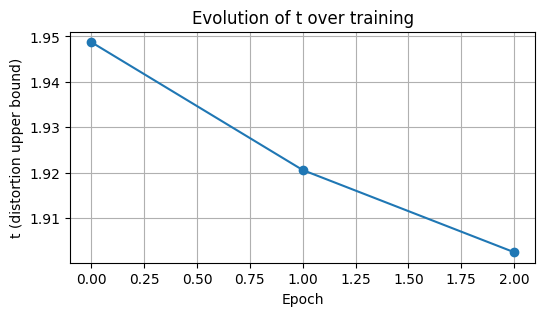

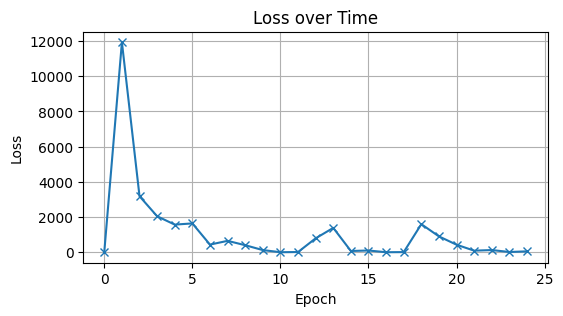

Solving CVX for each X:   0%|          | 0/1 [00:11<?, ?it/s]

Failure:interrupted


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [104]:
#X = X_init.clone().detach().requires_grad_(True)
X = X_gaussian[2].detach().clone().requires_grad_(True) 
t_init, Q_init = solve_cvx_for_history([X.clone().detach()], compute_D)
lhs_fixed = compute_lhs(torch.tensor(Q_init[0]))

optimizer = torch.optim.Adam([X], lr=1e-3)

best_t_cvx_train = -float('inf')
best_X_cvx_train = None  # Will hold the best X (i.e. when t is largest)
loss_history_cvx_train = []
t_history_cvx_train = [t_init[0]]
Q_history_cvx_train = [Q_init[0]]
max_norm_history_cvx_train = []
X_history_cvx_train = []

for epoch in range(50):

    optimizer.zero_grad()
    loss = loss_fn(X, lhs_fixed)
    loss.backward()

    compute_cvx = False
    with torch.no_grad():
        X_history_cvx_train.append(X.clone().detach())
        t, max_indices = get_t_and_violations(lhs_fixed, compute_D(X))
        max_norm = torch.norm(X, dim=0).max().item()
        max_norm_history_cvx_train.append(max_norm)
        if t is not None:
            compute_cvx = True
        else:
            t_val = None


    optimizer.step()

    if compute_cvx:
        t_temp, Q_temp = solve_cvx_for_history([X.clone().detach()], compute_D)
        lhs_fixed = compute_lhs(torch.tensor(Q_temp[0]))
        t_val = t_temp[0]
        t_history_cvx_train.append(t_val)
        if t_val > best_t_cvx_train:
            best_t_cvx_train = t_val
            best_X_cvx_train = X.detach().clone()


    loss_history_cvx_train.append(loss.item())

    #print(max_norm)
    # Show evolving plot and stats
    update_plot_jupyter(X, epoch, t_val, max_indices)

    if t_history_cvx_train:
        update_t_plot(t_history_cvx_train)
        update_loss_plot(loss_history_cvx_train)
        #update_max_norm_plot(max_norm_history_cvx_train)



In [ ]:
proj_best_X = project_to_fundamental_domain(best_X)
savemat('../saved_data/python/25/X.mat', {'X': proj_best_X.cpu().numpy()})

## CVX

In [ ]:
t_hist_cvx, Q_hist_cvx = solve_cvx_for_history(X_history, compute_D)

Solving CVX for each X: 100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


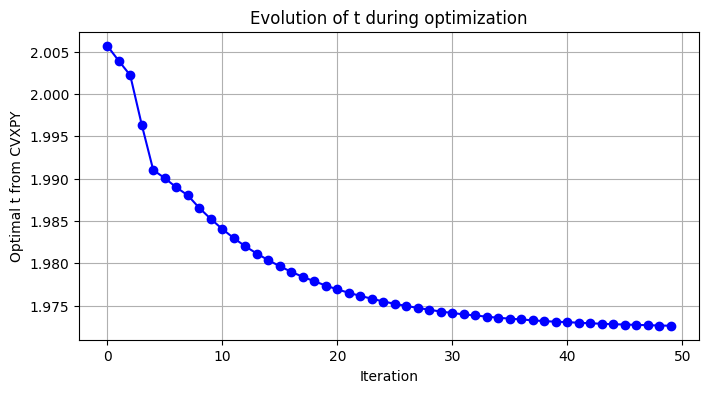

In [ ]:
t_vals = [val if val is not None else float('nan') for val in t_hist_cvx]

plt.figure(figsize=(8,4))
plt.plot(t_vals, marker='o', linestyle='-', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Optimal t from CVXPY')
plt.title('Evolution of t during optimization')
plt.grid(True)
plt.show()

# Uniform Sampling

In [ ]:
Y = create_X(49)

t_init, Q_init = solve_cvx_for_history([Y], compute_D)

t_init

Solving CVX for each X:   0%|          | 0/1 [00:00<?, ?it/s]/Users/yousef/miniconda3/envs/aspire/lib/python3.9/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Solving CVX for each X: 100%|██████████| 1/1 [00:28<00:00, 28.68s/it]


[array(1.96442744)]